# Value at Risk and Conditional Value at Risk

In this chapter, we'll be looking at two important statistics of risk management when trading currencies: the Value at Risk (VaR) and the Conditional VaR (CVaR). As always, these notebooks are not concerned in teaching you the theoretical concepts in detail (there are enough webpages out there which will do a far better job). Instead, we brute force theory in your brain with raw mathematics and a hands-on practical example. Ahhh, the true data hacker way.

The main goal of this session is to show you why RISK is best seen as a flashing red light in your mind, deserving all your attention while trading. But what is risk? Between us, young padawan, we'll agree that risk is simply the amount of money you're about to lose. We need to somehow be able to estimate the risk we're about to take when we'll enter the market. Otherwise you'll go for coffee and come back with a brick in your window and your kidney gone. Stay safe out there kids, markets can move fast and banks are mafias.

## Long-tailed return distributions

Let's start off by looking at the amount a currency value can move in a given time: the return distribution. 

D:\Programs_x64\Anaconda2\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


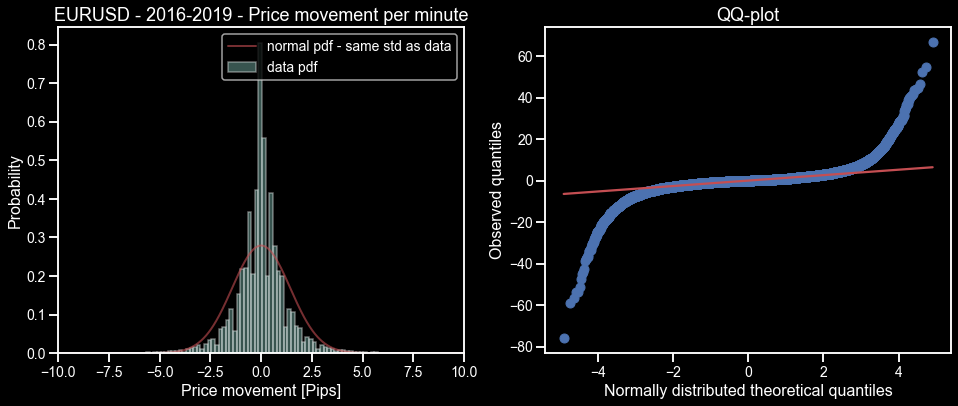

D:\Programs_x64\Anaconda2\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


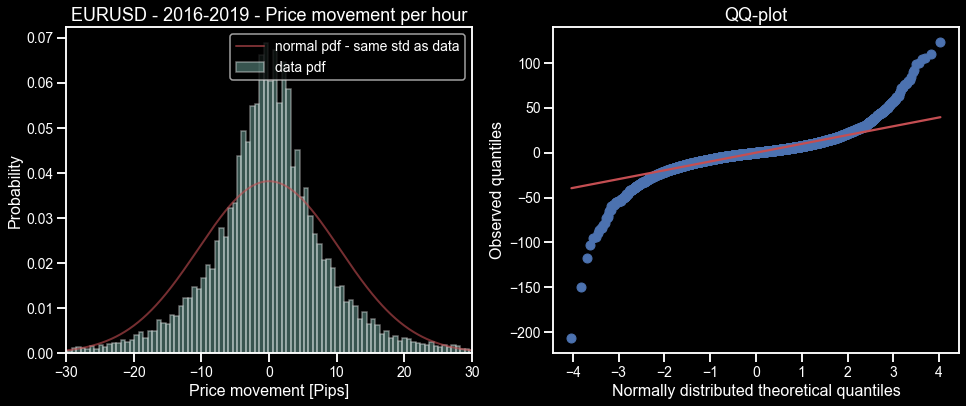

D:\Programs_x64\Anaconda2\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


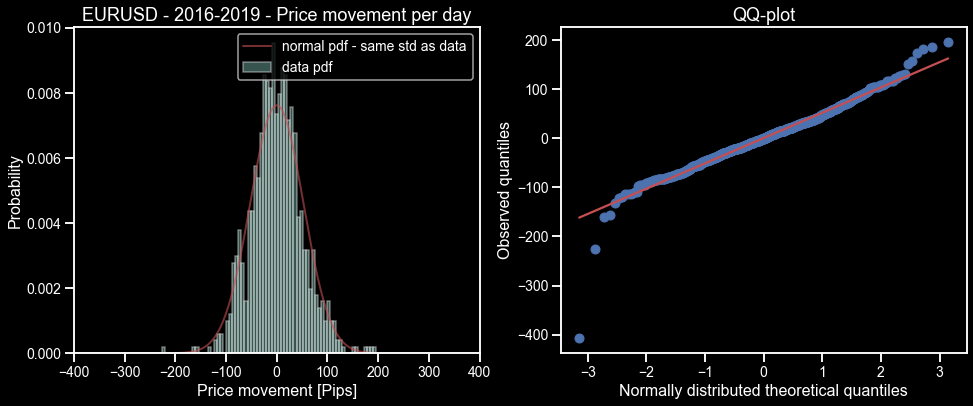

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, probplot

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

fn = "datasets/EURUSD_20162019_M1.csv"
data = pd.read_csv(fn, index_col = 0, parse_dates=True, dtype={'close':np.float64})#, 'ask_close':np.float64})
close = data.close * 10**4 #convert rate to Pips.

#Set some plotting parameters based on the sample duration
for samplefreq in ['1min', '1H', '1D']:
    if samplefreq == '1min':
        close_sampled = close.copy()
        x_lim_range = 10
        bins = 800
        title_freq = 'minute'
    elif samplefreq == '1H':
        close_sampled = close.resample('1H').ohlc().close
        x_lim_range = 30
        bins = 500
        title_freq = 'hour'   
    elif samplefreq == '1D':
        close_sampled = close.resample('1D').ohlc().close
        x_lim_range = 400
        bins = 100
        title_freq = 'day'

    #get returns
    close_return = close_sampled.diff()
    close_return = close_return.dropna(axis=0)

    #generate a normal distribution to compare
    mu = close_return.mean()
    sigma = close_return.std()
    x = np.linspace(-x_lim_range,x_lim_range,1000)
    y_norm = norm.pdf(x,loc=mu,scale=sigma)

    #PLOT histogram
    fs1 = 18
    fs2 = 16
    fs3 = 14

    fig, axes = plt.subplots(1,2,figsize=(16,6))
    sns.distplot(close_return, kde=True, bins=bins, label='data pdf', ax=axes[0])
    axes[0].set_xlim(-x_lim_range,x_lim_range)
    axes[0].set_title("EURUSD - 2016-2019 - Price movement per {}".format(title_freq), fontsize=fs1)
    axes[0].set_xlabel("Price movement [Pips]", fontsize=fs2)
    axes[0].set_ylabel("Probability", fontsize=fs2)
    #remove density line from seaborn
    axes[0].get_lines()[0].remove()
    #change fontsize of ticks
    axes[0].tick_params(axis='both', which='major', labelsize=fs3)
    #plot normal distributions
    axes[0].plot(x, y_norm, lw=2, alpha=0.6, label='normal pdf - same std as data', color='r')
    axes[0].legend(prop={'size': fs3})

    probplot(close_return, plot=axes[1])
    axes[1].set_title("QQ-plot", fontsize=fs1)
    axes[1].set_xlabel("Normally distributed theoretical quantiles", fontsize=fs2)
    axes[1].set_ylabel("Observed quantiles", fontsize=fs2)
    axes[1].tick_params(axis='both', which='major', labelsize=fs3)
    #plt.rcParams.update({'font.size': 16})

    plt.show()


B-e-a-utiful. If distributions don't turn you on than what does? 
*The* most important information in these plots is that **intra-day price movements do not behave like a normal distribution.** Instead, they follow a **long-tailed distribution**. We can easily see that by looking at the first Quantile-Quantile (QQ) plot. To intuitively understand a QQ-plot, imagine taking the same amount of random samples from a normal distribution as we have in our dataset. If the dataset is normally distributed, the proportion of datasamples we have with small values compared to large values should be similar to the proportion of small to large values in an normal distribution. The per-minute data shows that way more samples are found in the tails of the distribution than we should expect had it been a normal distribution. If it were a normal distribution, the blue dots would have followed the red line (i.e. the quantiles would align). 

This is veeeeery important, because many statistical approaches assume the noise in the market to be normally distributed! Starting with that assumption, statistical models instantly fail to provide a correct estimate of the risk! A model that assumes the price to follow a normal probability distribution will tell you there is about zero chance the price could drop 20 pips in one minute. However, the market shows that a 20 pip drop does happen, and it happens often! 

What does all of this have to do with VaR and CVaR? Patience, young padawan. Eager you are to learn, I see. Very well. Stephen, bring in the math!

## Value-at-Risk (VaR)

Assume $\Delta V(t)$ equals the change in a currency pair, $t$ timesteps in the future, and $L(t)$ the corresponding lossfunction w.r.t. a position in the market. For a *long position*, $L(t) = -\Delta V(t)$ and for a *short position* $L(t) = \Delta V(t)$. The Value at Risk is then defined with corresponding probability $p$ as

\begin{equation}
    p = Pr[L(t) \geq VaR]
\end{equation}

In words: the probability that a position will result in a loss greater than or equal to the VaR over a timehorizon t is p. It follows that the VaR can be seen as the (1-p)-th quantile of the cumulatief distribution function of L(t):

\begin{equation}
     1-p = Pr[L(t) < VaR]
\end{equation}

In the context of the FX market, the VaR is mostly calculated for p = 0.01 or p = 0.05. The time horizon would then for instance be 1 hour or 1 day. The VaR corresponding to probability $1-p$ (last equation) can also be written as $VaR_{1-p}$.

## Conditional Value at Risk (CVaR)
**As the VaR only represents a quantile, it can lead to a significant underestimation of the potential loss if $\Delta V(t)$ follows a long-tailed distribution.** A better estimation of the potential loss is therefore the expected value of $L(t)$ given that the VaR is surpassed. This expected value is called the *Expected Shortfall* or *Conditional Value at Risk*:
\begin{equation}
    CVaR_{1-p} = \frac{1}{p} \int_{0}^{p} VaR_{1-q} dq
\end{equation}


## Demonstration

Let's have a look at the VaR and CVaR of the EURUSD pair sampled to t = 1 hour for p = 0.05. We'll assume we want to take a long position.

In [35]:
#close_sampled = close.copy()
close_sampled = close.resample('1H').ohlc().close
close_return = close_sampled.diff()
close_return = close_return.dropna(axis=0)
p = 0.05

hist, edges = np.histogram(close_return, 1000)
pdf = hist / np.sum(hist)
cdf = np.cumsum(pdf)
var_index = np.where(cdf > p)[0][0]
var = edges[var_index]

cvar = np.sum(pdf[:var_index] * edges[:var_index] / np.sum(pdf[:var_index]))

print("Value at Risk: {}\nConditional Value at Risk: {}".format(var,cvar))

Value at Risk: -15.28400000000218
Conditional Value at Risk: -24.462376872966477


In [ ]:
#Check what Var and CVaR would be for a normal distribution with the same std.